# VAE: CelebA Latent 2D

## 데이터 다운로드

In [ ]:
# 이미지 데이터
!gdown 16az93r2kw6d903Mv4hb1Q0Fz4TOlKWjA # metamath/sdata

Downloading...
From (original): https://drive.google.com/uc?id=16az93r2kw6d903Mv4hb1Q0Fz4TOlKWjA
From (redirected): https://drive.google.com/uc?id=16az93r2kw6d903Mv4hb1Q0Fz4TOlKWjA&confirm=t&uuid=eda23f99-7695-4201-9f00-5544f4760bfa
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:14<00:00, 102MB/s]


In [ ]:
# 이미지에 대한 레이블 데이터
!gdown 16bWjUStBdWhN1F-uC3TVdYGpJSm41E41 # metamath/sdata

Downloading...
From: https://drive.google.com/uc?id=16bWjUStBdWhN1F-uC3TVdYGpJSm41E41
To: /content/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 212MB/s]


In [ ]:
# 이미지 파일 압축 풀기
!unzip -qq img_align_celeba.zip

In [ ]:
# 미리 학습한 파라미터 다운
!gdown 1XTl8fS_XewaWr3nQ4n4tX-jhI6AenYva

Downloading...
From (original): https://drive.google.com/uc?id=1XTl8fS_XewaWr3nQ4n4tX-jhI6AenYva
From (redirected): https://drive.google.com/uc?id=1XTl8fS_XewaWr3nQ4n4tX-jhI6AenYva&confirm=t&uuid=90d5490a-8243-4033-aa7c-e3fffa643b7c
To: /content/best_vae_celeba_2d.pt
100% 26.8M/26.8M [00:00<00:00, 63.1MB/s]


## 패키지 임포트 & 기타 설정값 세팅

In [ ]:
# import the necessary packages
import glob
import os, random
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm

In [ ]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
DEVICE

'cuda'

In [ ]:
# define model hyperparameters
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 32
EMBEDDING_DIM = 256
KLD_WEIGHT = 0.000001

# define the dataset path
DATASET_PATH = "img_align_celeba"
DATASET_ATTRS_PATH = "list_attr_celeba.txt"


In [ ]:
# 이미지에 대한 속성 정보를 판다스로 읽음
# 이 예제에서는 웃음에 대한 특징을 사용하기 위해 제일 마지막 부분에 사용
df_attrs = pd.read_csv(DATASET_ATTRS_PATH, sep='\s+', skiprows=1, index_col=0)
LABELS = list(df_attrs.columns)
print(LABELS)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


## 모델링


### 손실함수




In [ ]:
def loss_function(VAELossParams, kld_weight):
    recons, input, mu, log_var = VAELossParams

    # 이미지가 얼마나 잘 복원되었는지에 대한 MSE 로스
    recons_loss = F.mse_loss(recons, input)

    # latent_dim으로 합하고, 샘플에 대해서 평균
    # 마지막 특징이 (N, C, H, W) 이기 때문에 sum할때 axis=1,2,3에 다 합해야 함
    kld_loss = torch.mean(
        -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=(1,2,3)), dim=0
    )

    loss = recons_loss + kld_weight * kld_loss

    return {
        "loss": loss,
        "Reconstruction_Loss": recons_loss.detach(),
        "KLD": kld_loss.detach(),
    }

### 단위 컨볼루션 레이어



#### ConvBlock

- Conv - Batch Norm. - LeakyReLU 순으로 묶음

- 기본값
    - 커널 사이즈: 3x3
    - stride: 2
    - padding: 1

In [ ]:
# define a convolutional block for the encoder part of the vae
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size=3, stride=2, padding=1) -> None:
        super(ConvBlock, self).__init__()
        # sequential block consisting of a 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,  # number of input channels
                out_channels=out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
            ),
            nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            nn.LeakyReLU(),  # apply leaky relu activation
        )
    def forward(self, x):
        # pass the input through the sequential block
        return self.block(x)

#### ConvTBlock

- ConvBlock의 반대 연산으로 컨볼루션을 진행하면 H, W가 두배로 늘어남

In [ ]:
# define a transposed convolutional block for the decoder part of the vae
class ConvTBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(ConvTBlock, self).__init__()
        # sequential block consisting of a transposed 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,  # number of input channels
                out_channels,  # number of output channels
                kernel_size=3,  # size of the convolutional kernel
                stride=2,  # stride of the convolution
                padding=1,  # padding added to the input
                output_padding=1,  # additional padding added to the output
            ),
            nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            nn.LeakyReLU(),  # apply leaky relu activation
        )
    def forward(self, x):
        return self.block(x)  # pass the input through the sequential block

### 전체 모델

In [ ]:
# define the main vae class
class CelebVAE(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int, hidden_dims: List = None) -> None:
        super(CelebVAE, self).__init__()

        self.latent_dim = latent_dim  # dimensionality of the latent space
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]  # default hidden dimensions
            # img size 128->64  32   16   8    4

        self.hidden_dims = hidden_dims[:]
        self.feature_map_hw = int(IMAGE_SIZE / 2**len(hidden_dims))

        # build the encoder using convolutional blocks
        # self.encoder = nn.Sequential(
        #     *[
        #         # create a convblock for each pair of input and output channels
        #         ConvBlock(in_f, out_f)
        #         for in_f, out_f in zip([in_channels] + hidden_dims[:-1], hidden_dims)
        #     ]
        # )
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, hidden_dims[0]),    # (N, 3, 128, 128) -> (N, 32, 64, 64)
            ConvBlock(hidden_dims[0], hidden_dims[1]), # (N, 32, 64, 64) -> (N, 64, 32, 32)
            ConvBlock(hidden_dims[1], hidden_dims[2]), # (N, 64, 32, 32) -> (N, 128, 16, 16)
            ConvBlock(hidden_dims[2], hidden_dims[3], stride=1), # (N, 128, 16, 16) -> (N, 256, 16, 16)
            ConvBlock(hidden_dims[3], hidden_dims[4], stride=1)  # (N, 256, 16, 16) -> (N, 512, 16, 16)
        )

        # conv layer for the mean of the latent space
        # self.fc_mu = nn.Linear(hidden_dims[-1] * self.feature_map_hw**2, latent_dim)
        # (N, 512, 16, 16) -> (N, latent_dim, 16, 16)
        self.conv_mu = nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)

        # conv layer for the variance of the latent space
        # (N, 512, 16, 16) -> (N, latent_dim, 16, 16)
        self.conv_var = nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)

        # 잠재변수 z를 다시 디코더 인풋으로 확장 하는 레이어
        # self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.feature_map_hw**2)
        # (N, latent_dim, 16, 16) -> (N, 512, 16, 16)
        self.decoder_input = nn.Conv2d(latent_dim, hidden_dims[-1], kernel_size=3, stride=1, padding=1)

        hidden_dims.reverse()  # reverse the hidden dimensions for the decoder
        # hidden_dims은 여기서 부터 [512, 256, 128, 64, 32]

        # self.decoder = nn.Sequential(
        #     *[
        #         # create a convtblock for each pair of input and output channels
        #         ConvTBlock(in_f, out_f)
        #         for in_f, out_f in zip(hidden_dims[:-1], hidden_dims[1:])
        #     ]
        # )
        self.decoder = nn.Sequential(
            ConvBlock(hidden_dims[0], hidden_dims[1], stride=1), #(N, 512, 16, 16) -> (N, 256, 16, 16)
            ConvBlock(hidden_dims[1], hidden_dims[2], stride=1), #(N, 256, 16, 16) -> (N, 128, 16, 16)
            ConvTBlock(hidden_dims[2], hidden_dims[3]), #(N, 128, 16, 16) -> (N, 64, 32, 32)
            ConvTBlock(hidden_dims[3], hidden_dims[4]), #(N, 64, 32, 32) -> (N, 32, 64, 64)
        )

        # final layer to reconstruct the original input
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            # normalize the activations of the layer
            nn.BatchNorm2d(hidden_dims[-1]),
            # apply leaky relu activation
            nn.LeakyReLU(),
            # final convolution to match the output channels
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
        )

    # encoding function to map the input to the latent space
    def encode(self, input: Tensor) -> List[Tensor]:
        # pass the input through the encoder
        result = self.encoder(input) # (N, 3, 64, 64)->(N, 512, 16, 16)

        # flatten the result for the fully connected layers
        # result = torch.flatten(result, start_dim=1) # (N, 512, 4, 4) -> (N, 512*4*4)

        # compute the mean of the latent space
        mu = self.conv_mu(result) # (N, 512, 16, 16) -> (N, latent_dim, 16, 16)

        # compute the log variance of the latent space
        log_var = self.conv_var(result) # (N, 512, 16, 16) -> (N, latent_dim, 16, 16)

        return [mu, log_var]

        # decoding function to map the latent space to the reconstructed input
    def decode(self, z: Tensor) -> Tensor:
        # expand the latent space
        result = self.decoder_input(z) # (N, latent_dim, 16, 16) -> (N, 512, 16, 16)

        # reshape the result for the transposed convolutions
        # result = result.view(-1, 512, 4, 2) # (N, 512*2*2) -> (N, 512, 2, 2)
        # result = result.view(-1, self.hidden_dims[-1], self.feature_map_hw, self.feature_map_hw)

        # pass the result through the decoder
        result = self.decoder(result) # (N, 512, 16, 16) -> (N, 32, 64, 64)

        # pass the result through the final layer
        result = self.final_layer(result) # (N, 32, 64, 64)->(N, 32, 128, 128)->(N, 3, 128, 128)
        return result

        # reparameterization trick to sample from the latent space
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        # compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # sample random noise
        eps = torch.randn_like(std)
        # compute the sample from the latent space
        return eps * std + mu

    # forward pass of the vae
    def forward(self, input: Tensor) -> List[Tensor]:
        # encode the input to the latent space
        # (N, 3, 128, 128) -> [(N, latent_dim, 16, 16), (N, latent_dim, 16, 16)]
        mu, log_var = self.encode(input)

        # sample from the latent space
        z = self.reparameterize(mu, log_var) # (N, latent_dim, 16, 16)

        # decode the sample, and return the reconstruction
        # along with the original input, mean, and log variance
        return [
            self.decode(z),
            input,
            mu,
            log_var
        ]

In [ ]:
# create output directory
output_dir = "output"
os.makedirs("output", exist_ok=True)

# create the training_progress directory inside the output directory
training_progress_dir = os.path.join(output_dir, "training_progress")
os.makedirs(training_progress_dir, exist_ok=True)

# create the model_weights directory inside the output directory
# for storing autoencoder weights
model_weights_dir = os.path.join(output_dir, f"model_weights_latent2D_{EMBEDDING_DIM}")
os.makedirs(model_weights_dir, exist_ok=True)

# define model_weights path including best weighs
MODEL_BEST_WEIGHTS_PATH = os.path.join(model_weights_dir, "best_vae_celeba_2d.pt")
MODEL_WEIGHTS_PATH = os.path.join(model_weights_dir, "vae_celeba_2d.pt")


In [ ]:
# 미리 다운 받은 best_vae_celeba_2d.pt 파일이 있으면 model_weights_dir 밑으로 이동
import shutil

if os.path.exists("./best_vae_celeba_2d.pt"):
    shutil.move("./best_vae_celeba_2d.pt", MODEL_BEST_WEIGHTS_PATH)

### 이미지 오그먼테이션 설정

In [ ]:
# Define the transformations
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(148),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(148),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

### 데이터 셋과 데이터 로더

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.all_images = list(glob.iglob(root_dir + "/*.jpg"))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
seed = 0

# 전역 난수 생성기 시드 설정
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python의 random 모듈
    np.random.seed(seed_value)  # Numpy 모듈
    torch.manual_seed(seed_value)  # PyTorch를 위한 시드 설정
    torch.cuda.manual_seed_all(seed_value)  # 모든 GPU에 대한 PyTorch 시드 설정
    # torch.backends.cudnn.deterministic = True  # CUDNN을 결정적으로 설정 (속도는 느려질 수 있음)
    # torch.backends.cudnn.benchmark = False  # CUDNN 벤치마크를 끔 (속도는 느려질 수 있음)

set_seed(seed)  # 시드 값을 설정합니다.

# Instantiate the dataset
print(DATASET_PATH)
celeba_dataset = CelebADataset(DATASET_PATH, transform=train_transforms)
print("# total sample: ", len(celeba_dataset))

# Define the size of the validation set
val_size = int(len(celeba_dataset) * 0.1)  # 10% for validation
train_size = len(celeba_dataset) - val_size
print("# train sample: ", train_size, "# val sample: ", val_size)

# 시드가 고정된 난수 생성기를 생성
g = torch.Generator()
g.manual_seed(seed)
# 데이터셋 분할 시 난수 생성기 전달
train_dataset, val_dataset = random_split(
    celeba_dataset,
    [train_size, val_size], generator=g
)

# Define the data loaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

img_align_celeba
# total sample:  202599
# train sample:  182340 # val sample:  20259


### 에폭과 모델 생성

In [ ]:
EPOCHS = 10

model = CelebVAE(CHANNELS, EMBEDDING_DIM)
model = model.to(DEVICE)

### 옵티마이저 세팅

- Adam 옵티마이저 사용

- 학습률 스케쥴러를 세팅
    - 레퍼런스: https://panggu15.github.io/etc/pytorch-learning-rate-Scheduler/


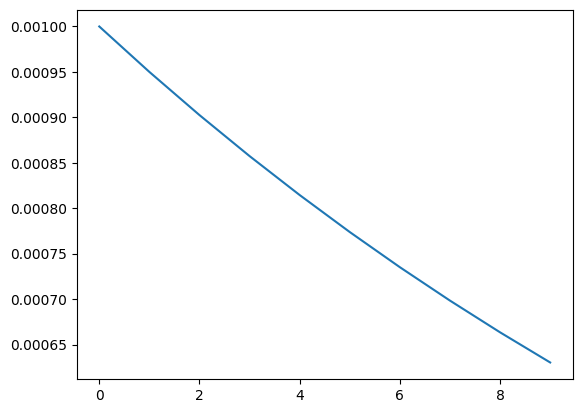

0.001

In [ ]:
# instantiate optimizer, and scheduler
# LR = 0.003 # 0.001 #0.005
learning_rate = 0.001
gamma = 0.95
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# lr_scheduler 실험
lrs = []
for i in range(EPOCHS):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(EPOCHS),lrs)
plt.show()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
optimizer.param_groups[0]['lr']

### 포워드 테스트

x_test:  torch.Size([5, 3, 128, 128])
reconstruction:  torch.Size([5, 3, 128, 128])


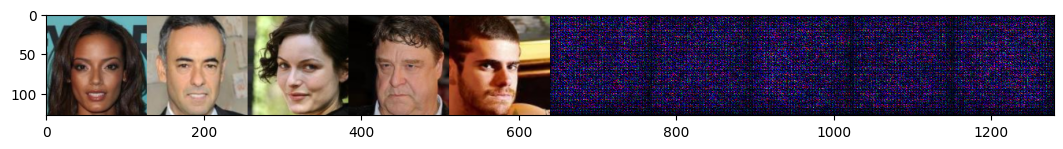

In [ ]:
val_loader_iter = iter(val_dataloader)

# 샘플 5개 가져오기
x_test = next(val_loader_iter)[:5].clone().to(DEVICE)
print('x_test: ', x_test.shape)

# 예측
predictions = model(x_test)
print('reconstruction: ', predictions[0].shape)

fig = plt.figure(figsize=(13,5))
plt.imshow(
    # x_test이미지 5장과 출력 이미지 5장을 나란히 이어붙이기
    # (5, 3, 128, 128), (5, 3, 128, 128) -> (10, 3, 128, 128)
    # (10, 3, 128', 128) -> (128', 10, 128, 3) -> (128', 128*10, 3)
    torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1)
)
plt.show()

### 검증 로스 계산 함수

- 학습 중에 이 함수를 사용해서 검증 데이터 에 대한 로스를 계산

In [ ]:
def validate(mode, val_dataloader, DEVICE):
    running_loss = 0.0
    model.eval()

    with torch.no_grad():
        for i, x in enumerate(val_dataloader):
            x = x.to(DEVICE)
            predictions = model(x)
            total_loss = loss_function(predictions, KLD_WEIGHT)
            running_loss += total_loss["loss"].item()

    return running_loss / len(val_dataloader)

## 학습

In [ ]:
%%time

# initialize the best validation loss as infinity
best_val_loss = float("inf")
print("Training Started!!")

# start training by looping over the number of epochs
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for i, x in enumerate(tqdm(train_dataloader)):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        predictions = model(x)
        total_loss = loss_function(predictions, KLD_WEIGHT)

        # Backward pass
        total_loss["loss"].backward()

        # Optimizer variable updates
        optimizer.step()

        running_loss += total_loss["loss"].item()

    # compute average loss for the epoch
    train_loss = running_loss / len(train_dataloader)

    # compute validation loss for the epoch
    val_loss = validate(model, val_dataloader, DEVICE)

    # save best vae model weights based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({"vae-celeba": model.state_dict()}, MODEL_BEST_WEIGHTS_PATH)
    torch.save({"vae-celeba": model.state_dict()}, MODEL_WEIGHTS_PATH)

    print(
        f"Epoch {epoch+1}/{EPOCHS}, Batch {i+1}/{len(train_dataloader)}, "
        f"Total Loss: {total_loss['loss'].detach().item():.4f}, "
        f"Reconstruction Loss: {total_loss['Reconstruction_Loss']:.4f}, "
        f"KL Divergence Loss: {total_loss['KLD']:.4f}",
        f"Val Loss: {val_loss:.4f}",
    )

    if 1: # epoch % 5 == 0:
        model.eval()
        predictions = model(x_test)
        fig = plt.figure(figsize=(13,5))
        plt.imshow(torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
        plt.show()

        # 랜덤 노이즈에 대한 생성
        random_noise = torch.randn((5, EMBEDDING_DIM, 16, 16)).to(DEVICE)
        x_recon = model.decode(random_noise)
        # fig = plt.figure(figsize=(7,3))
        plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
        plt.show()

    scheduler.step()

Output hidden; open in https://colab.research.google.com to view.

## 실험

### 모델 불러오기

In [ ]:
# model load
# MODEL_BEST_WEIGHTS_PATH
# 저장된 모델 상태를 불러옵니다.
model_state = torch.load(MODEL_BEST_WEIGHTS_PATH, weights_only=True)

# 모델 상태를 현재 모델에 로드합니다.
model.load_state_dict(model_state['vae-celeba'])
model.eval();

### 샘플 재구성

- 학습에서 사용한 `x_test`에 대해서 인코딩, 디코딩

In [ ]:
# 인코딩
mu, log_var = model.encode(x_test)

# 샘플링
z = model.reparameterize(mu, log_var)

# 디코딩
x_recon = model.decode(z)

x_test.shape, z.shape, x_recon.shape

(torch.Size([5, 3, 128, 128]),
 torch.Size([5, 256, 16, 16]),
 torch.Size([5, 3, 128, 128]))

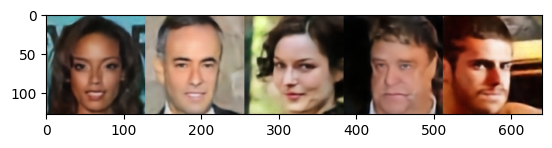

In [ ]:
plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

### 잠재변수(노이즈)로 부터 재구성

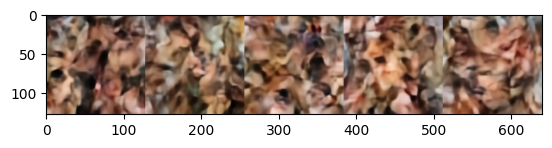

In [ ]:
random_noise = torch.randn_like(z)

x_recon = model.decode(random_noise)
plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()


### 이미지 인터폴레이션

In [ ]:
n = 20

from_idx, to_idx = 2, 1

encoded_1 = model.encode(x_test[from_idx:from_idx+1])
z_1 = model.reparameterize(encoded_1[0], encoded_1[1])

encoded_2 = model.encode(x_test[to_idx:to_idx+1])
z_2 = model.reparameterize(encoded_2[0], encoded_2[1])

z = torch.cat([z_1 + (z_2-z_1)*t for t in np.linspace(0,1,n)], axis=0)
print(z.shape)

interpol_list = model.decode(z)
interpol_list.shape


torch.Size([20, 256, 16, 16])


torch.Size([20, 3, 128, 128])

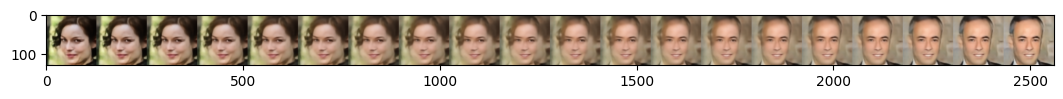

In [ ]:
fig = plt.figure(figsize=(13,5))
plt.imshow(interpol_list.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()


### 잠재변수의 분포 확인

torch.Size([160, 256, 16, 16])
torch.Size([65536, 160])
64


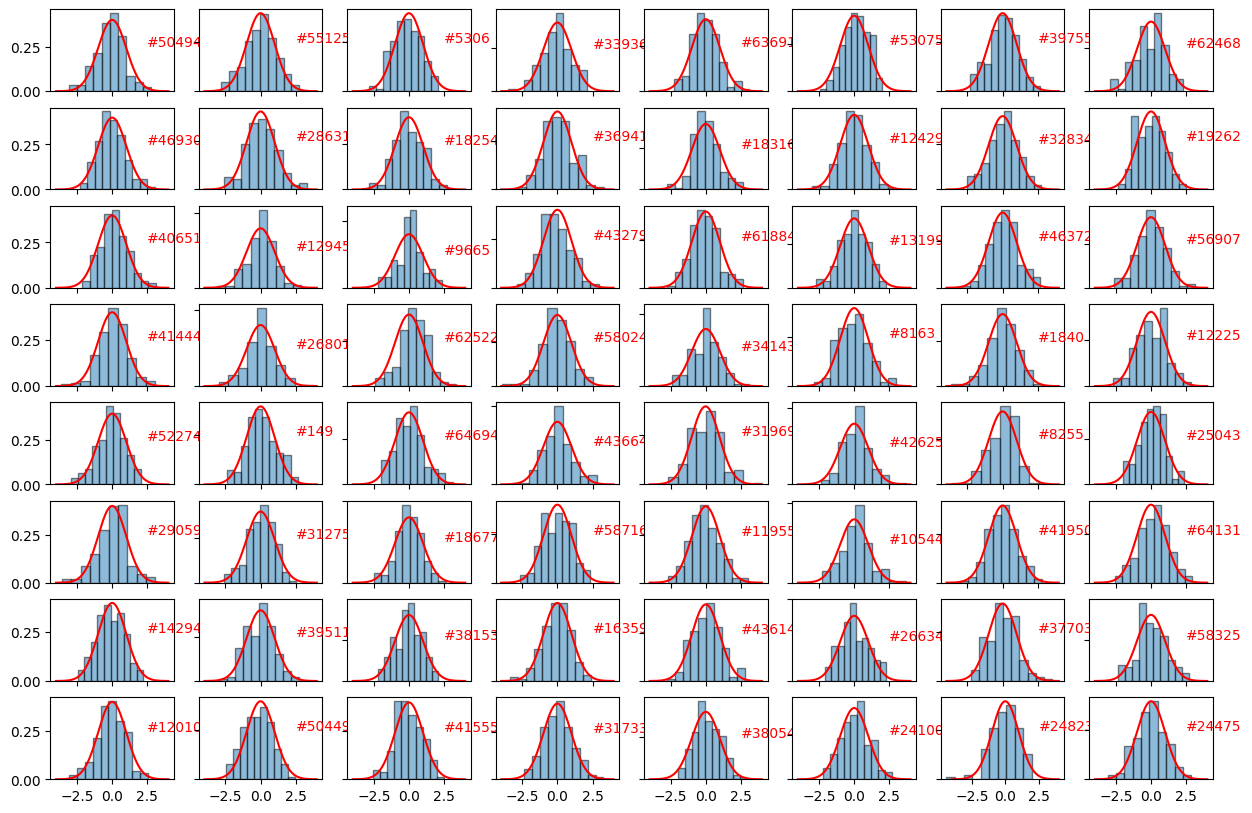

In [ ]:
# 인코더의 출력 z의 픽셀값 분포를 그려보기
from scipy.stats import norm
import random

# Define the range for the x-axis
x = np.linspace(-4, 4, 1000)

# Calculate the PDF of the standard normal distribution
pdf = norm.pdf(x, 0, 1)

# 32 샘플을 5번 모음 160개 샘플
x_test_for_pixel_dist = torch.cat([next(val_loader_iter) for i in range(5)], axis=0)
z_mu, z_logvar = model.encode(x_test_for_pixel_dist.to(DEVICE))
z_test = model.reparameterize(z_mu, z_logvar)
# 160개 샘플에 대한 128차원의 잠재 변수
print(z_test.shape)

z_test = z_test.reshape(BATCH_SIZE*5, -1).T
print(z_test.shape)

# 무작위로 64개의 픽셀을 잠재변수로 부터 무작위 추출
ids = random.sample(range(z_test.shape[0]), 64)

fig, axs = plt.subplots(figsize=(15,10), nrows=8, ncols=8)
print(len(ids))

for i, ax in enumerate(axs.flat):
    # 모든 샘플의 ids[i]번째 픽셀들
    z_j = z_test[ids[i]]
    ax.xaxis.set_tick_params(which='both', labelbottom=True if i >= 8*7 else False, bottom=True)
    ax.yaxis.set_tick_params(which='both', labelleft=True if i in range(0, 64, 8) else False, left=True)
    ax.hist(z_j.detach().cpu().numpy().reshape(-1), bins=10, ec='k', alpha=0.5, density=True)
    ax.text(2.5, 0.25, f"#{ids[i]}", color='r')
    ax.plot(x, pdf, color='r')

plt.show()

### 특징 합성

In [ ]:
def add_path(x):
    return DATASET_PATH + '/' + x

# 웃는 얼굴과 웃지 않는 얼굴에 대한 이미지를 분리
smiling_imgs     = list(df_attrs[df_attrs['Smiling'] == 1].reset_index()['index'].apply(add_path))
non_smiling_imgs = list(df_attrs[df_attrs['Smiling'] == -1].reset_index()['index'].apply(add_path))

# smiling - non_smiling
class CelebADatasetfromImageName(Dataset):
    def __init__(self, all_images, transform=None):
        self.transform = transform
        self.all_images = all_images

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

smiling_ds     = CelebADatasetfromImageName(smiling_imgs,     transform=val_transforms)
non_smiling_ds = CelebADatasetfromImageName(non_smiling_imgs, transform=val_transforms)

smiling_loader     = DataLoader(smiling_ds, batch_size=BATCH_SIZE)
non_smiling_loader = DataLoader(non_smiling_ds, batch_size=BATCH_SIZE)

len(smiling_ds), len(non_smiling_ds)

(97669, 104930)

- 웃는 얼굴에 대한 잠재 변수 평균

In [ ]:
smiling_latent = None

for i, x in enumerate(tqdm(smiling_loader)):
    encoded = model.encode(x.to(DEVICE))
    z = model.reparameterize(encoded[0], encoded[1]).detach().cpu()
    z = z.sum(axis=0) # (latent_size, )

    if smiling_latent == None:
        smiling_latent = z
    else:
        smiling_latent += z

smiling_latent /= len(smiling_ds)

smiling_latent.shape

100%|██████████| 3053/3053 [02:11<00:00, 23.19it/s]


torch.Size([256, 16, 16])

- 웃지 않는 얼굴에 대한 잠재 변수 평균

In [ ]:
non_smiling_latent = None

for i, x in enumerate(tqdm(non_smiling_loader)):
    encoded = model.encode(x.to(DEVICE))
    z = model.reparameterize(encoded[0], encoded[1]).detach().cpu()
    z = z.sum(axis=0)

    if non_smiling_latent == None:
        non_smiling_latent = z
    else:
        non_smiling_latent += z

non_smiling_latent /= len(non_smiling_ds)

non_smiling_latent.shape

100%|██████████| 3280/3280 [02:21<00:00, 23.22it/s]


torch.Size([256, 16, 16])

In [ ]:
# 웃음에 대한 의미만 남긴 잠재 벡터
smiling_vector = smiling_latent - non_smiling_latent

In [ ]:
mu, log_var = model.encode(x_test)
z = model.reparameterize(mu, log_var)
x_recon = model.decode(z)
z.shape, x_recon.shape


(torch.Size([5, 256, 16, 16]), torch.Size([5, 3, 128, 128]))

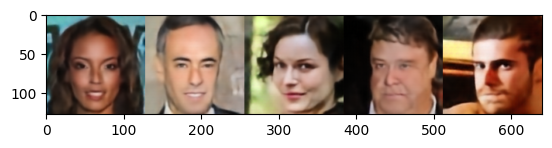

In [ ]:
plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()


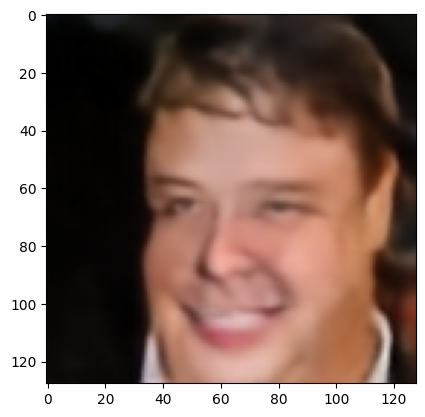

In [ ]:
# 웃지 않는 샘플의 인덱스
non_smile_idx = 3
z_smile = z[non_smile_idx] + 1.5*smiling_vector.to(DEVICE)

x_smile = model.decode(z_smile[np.newaxis, ...])
plt.imshow(x_smile.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

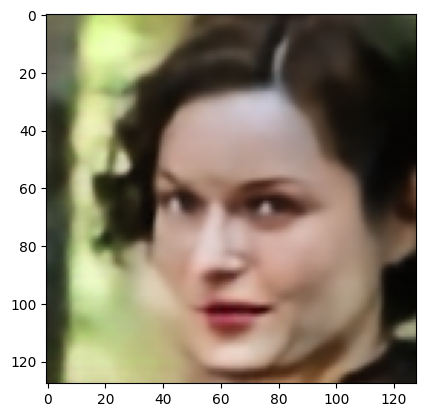

In [ ]:
# 웃는 샘플의 인덱스
smile_idx = 2
z_smile = z[smile_idx] - 0.8*smiling_vector.to(DEVICE)
x_smile = model.decode(z_smile[np.newaxis, ...])
plt.imshow(x_smile.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()
